# BikeSales

## Business Question
Can I predict the price of a motor bike for sale, and find the best deal?

- This could be provided to [bikesales.com] to improve customer experience. Providing a suggested price for sellers and buyers alike.
- This could be used as an external site to build a customer base that are looking for bikes on multiple websites. The website would be able to suggest the right bike to buy based on a small number of filters that a buyer is looking for. The site would then notify the buyer when a bike had become available on multiple websites that is a good deal, similar to [camelcamelcamel].

My main reason for this project is to find the best deal for a motorbike, as I want to buy one, which is why this will be focused mainly on sports bikes.

[bikesales.com]:(https://www.bikesales.com.au)
[camelcamelcamel]:(https://au.camelcamelcamel.com/)

## Data

I created a [webscraper] to extract all the information available from [bikesales.com]. The data was collected on a weekly basis from 1/6/19, resulting in over 3000 sports bikes in the data set.


[bikesales.com]:(https://www.bikesales.com.au)
[webscraper]:(https://github.com/beaubellamy/BikeSales/tree/master/BikeSales)



## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')


In [2]:
#Load the data and infer the date format for the date features
file = 'BikeSalesData-Road.csv'

df = pd.read_csv(file, 
                 #index_col=0,
                 parse_dates=['First_Seen','Last_Seen','Last Modified','Release Date'], 
                 dtype={'Postcode': 'category'},
                 dayfirst=True,
                 na_values='-')

In [3]:
print (df.shape)
df = df[df['Body'] == 'Super Sport'].reset_index(drop=True)
df.dropna(subset=['Make', 'Model', 'Price'],inplace=True)
print (df.shape)

df.head()

(4872, 224)
(3225, 224)


,Unnamed: 0,1st Gear Ratio,2nd Gear Ratio,3rd Gear Ratio,4th Gear Ratio,5th Gear Ratio,6th Gear Ratio,ABS,ABS Selectable,Acceleration,...,Front Differential Lock,Rear Differential Lock,Cup Holders,Tilt Steering,Roof,Rear Cargo Bed Length,Rear Cargo Bed Width,Driver Restraint,Passenger(s) Restraint,Unnamed: 223
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Drop known empty features
for col in list(df.columns):
    if 'Unnamed' in col:
        df.drop(col, axis=1, inplace=True)

        
# Drop any remaining target Null values from the dataframe
df = df[df['Price'].str.contains('Enquire') == False]
# All the information in the 'Bike' feature is split in to 'Make' and 'Model'
df.drop(['Bike'],axis=1, inplace=True)
df.shape

(3141, 208)

In [6]:
# Replace spaces with underscores in the feature list
df.columns = [col.replace('/', '_') for col in df.columns]
df.columns = [col.replace('-', '') for col in df.columns]
df.columns = [col.replace(' ', '_') for col in df.columns]
df.columns = [col.replace('__', '_') for col in df.columns]
# This is used to catch the cases like "Wet / Operational Weight", that would produce 3 '_' characters.
df.columns = [col.replace('__', '_') for col in df.columns] 

### Missing values
Look at the amount of missing data in each column, to decide on a threshold value to remove any features that have a large amount of missing data.

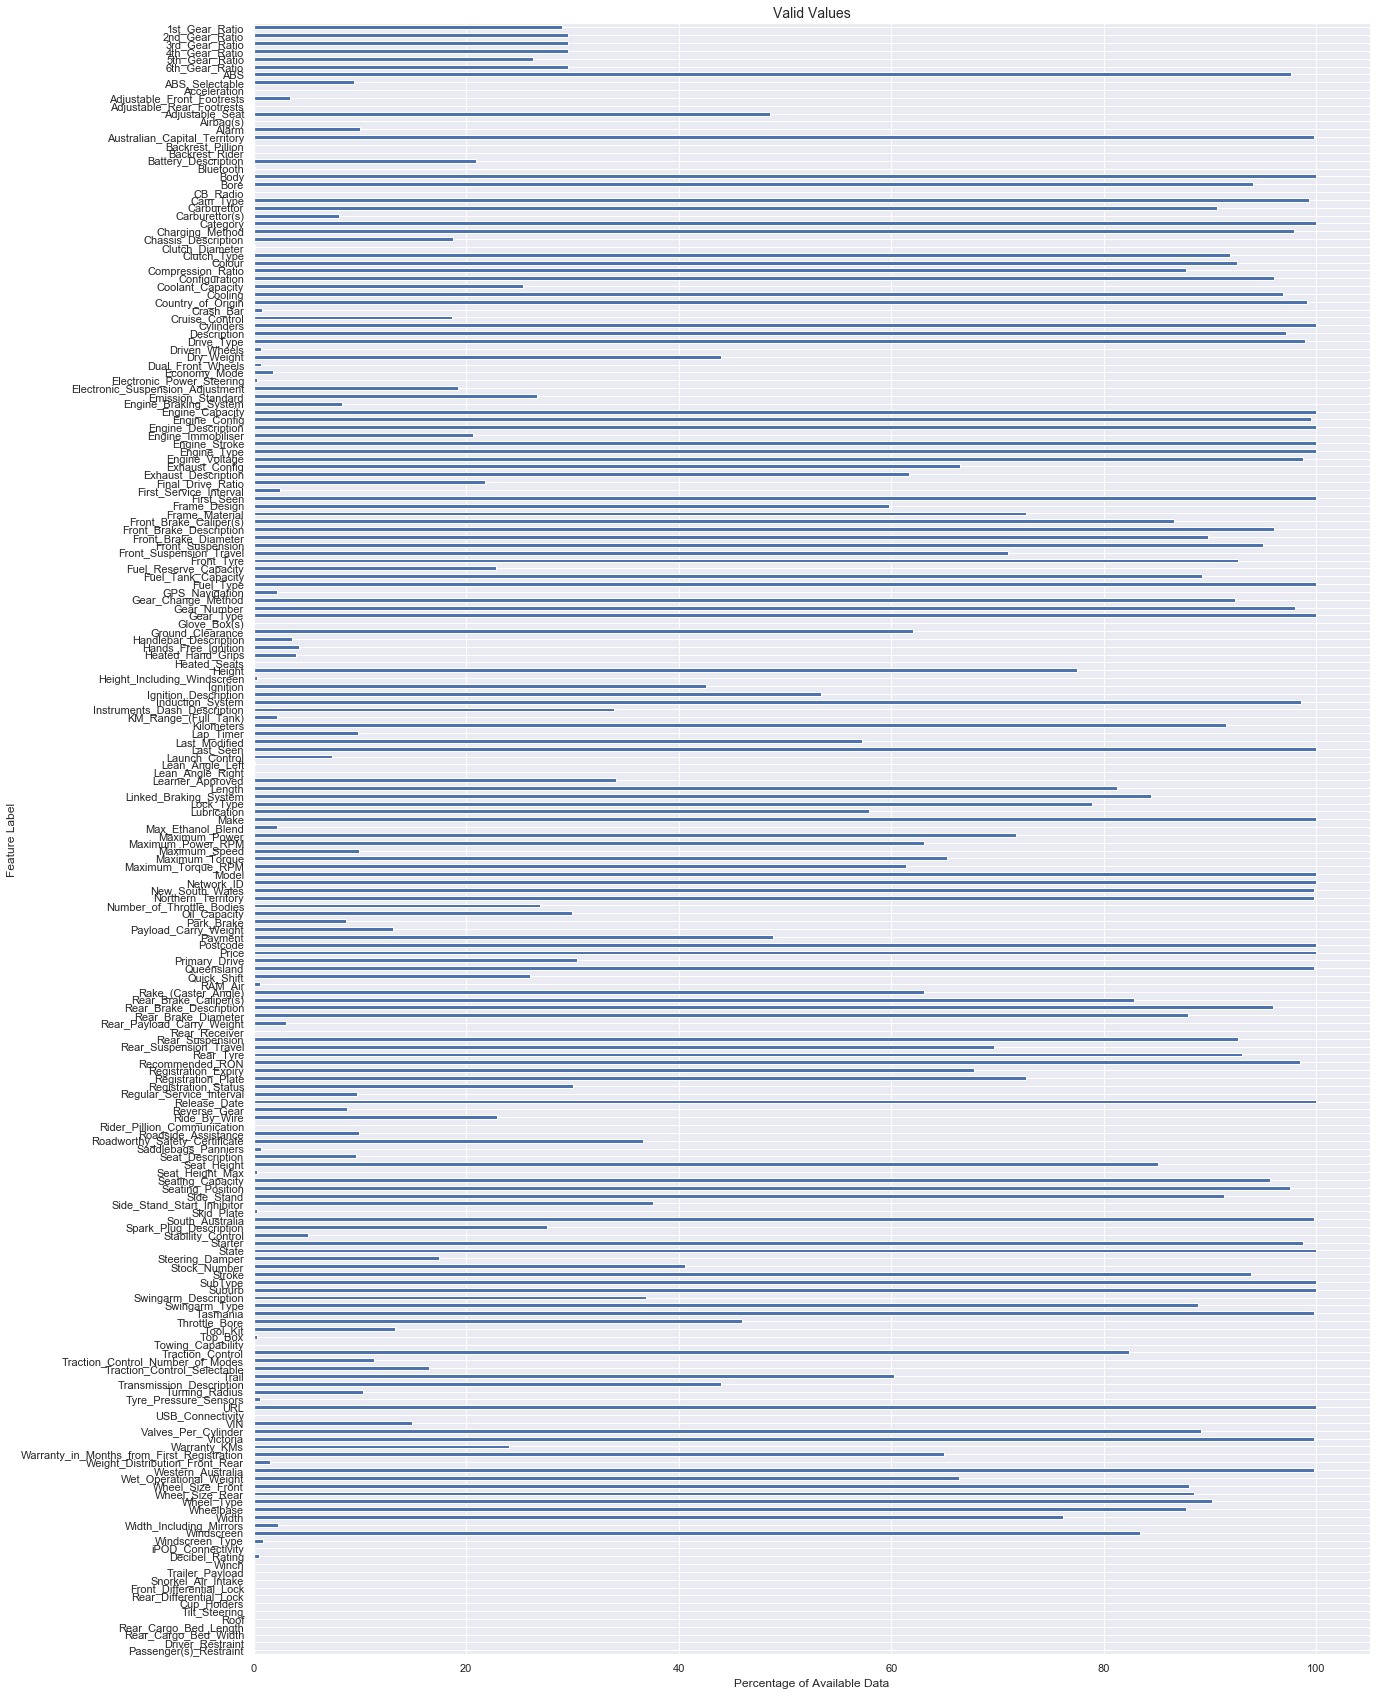

51.465% of data is missing 


In [7]:
# Alternatively display number of valid data as a percentage in a bar chart
def missing_bar(df,figsize=(20,20)):
    total = df.shape[0]
    missing = (total - df.isnull().sum())/total * 100
    missing.plot(kind='barh',figsize=figsize)
    plt.gca().invert_yaxis()
    plt.xlabel('Percentage of Available Data')
    plt.ylabel('Feature Label')
    plt.title('Valid Values', fontsize=14)
    plt.show()

    print('{}% of data is missing '.format(round(df.isnull().sum().sum()/float(df.size)*100,3)))
    

missing_bar(df, figsize=(20,30))

In [8]:
# Remove all features that have less than 10%  of data.

def remove_columns(df, null_threshold=0.9):
    '''
    Remove the columns that have a significant portion missing.
    
    df:             The dataframe that will be examined
    
    null_threshold: The threshold for permitted missing data;
                    Value must be between 0 and 1
                    (Default: 0.9)
    '''
    
    if ((null_threshold < 0) | (null_threshold >= 1)):
        warning('Threshold value is outside the bounds. Value must be between 0 and 1')
        return df
    
    minimum_null_threshold = null_threshold * df.shape[0]
    remove_list = []

    for col in list(df.columns):
        if (df[col].isnull().sum() > minimum_null_threshold):
            remove_list.append(col)

    print ('Columns before: ',len(df.columns))
    df.drop(remove_list,axis=1, inplace=True)
    print ('Columns after: ',len(df.columns))

    return df
    

In [9]:
# We specifically want to keep the learner legal flag.
df['Learner_Approved'][df['Learner_Approved'].isnull() == True] = 'No'

df = remove_columns(df, null_threshold=0.7)
print('{}% of data is missing '.format(round(df.isnull().sum().sum()/float(df.size)*100,3)))


Columns before:  208
Columns after:  113
16.962% of data is missing 


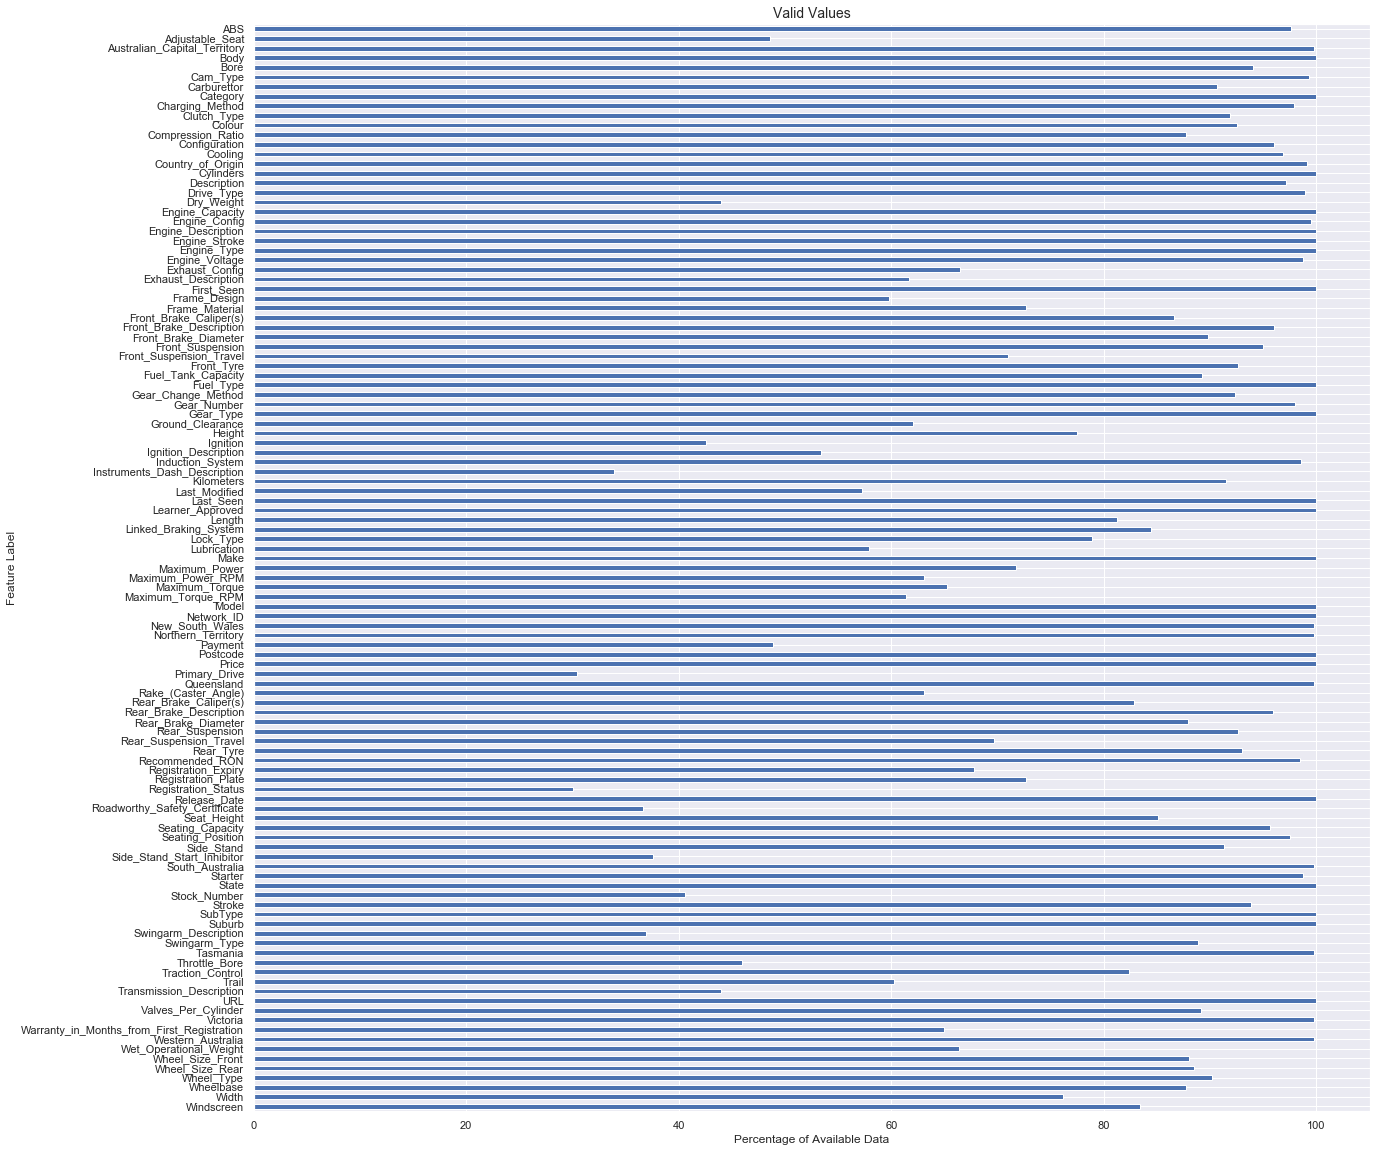

16.962% of data is missing 


In [10]:
missing_bar(df)

A feature requires 2 or more unique values to provide any predictive power. Ignoring any nan values, we can remove any features that have 1 unique value.

In [11]:
# Remove the columns where there is only 1 unique value
remove_list = []

for col in list(df.columns):
    # ignore nans in the list
    items = [x for x in list(df[col].unique()) if (str(x) != 'nan')]
    
    if ((len(items) == 1) & (col != 'Last_Seen')):
        remove_list.append(col)
        print (col,df[col].isnull().sum()/df.shape[0])

print ('Columns before: ',len(df.columns))
df.drop(remove_list,axis=1, inplace=True)
print ('Columns after: ',len(df.columns))


Australian_Capital_Territory 0.002228589621139764
Body 0.0
Category 0.0
Fuel_Type 0.0003183699458771092
New_South_Wales 0.002228589621139764
Northern_Territory 0.002228589621139764
Payment 0.5116205030245145
Queensland 0.002228589621139764
Registration_Status 0.699777141037886
Roadworthy_Safety_Certificate 0.6338745622413244
South_Australia 0.002228589621139764
SubType 0.0
Tasmania 0.002228589621139764
Victoria 0.002228589621139764
Western_Australia 0.002228589621139764
Windscreen 0.16555237185609678
Columns before:  113
Columns after:  97


Domain knowledge and research on technical terminology indicated several features that would not provide much value. These features were manually identified and removed.

In [12]:
# These features have been identified as not having much value based on domain knowledge and either
# they dont have many values, or they have too many unique values that could not be grouped to be 
# usefull.

remove = ['Engine_Capacity','Configuration','Description',
          'Exhaust_Description','Frame_Design','Front_Tyre',
          'Ignition_Description','Instruments_Dash_Description','Induction_System',
          'Lock_Type','Lubrication','Primary_Drive','Rear_Tyre',
          'Registration_Plate','Swingarm_Description',
          'Transmission_Description','Wheel_Size_Front','Wheel_Size_Rear']

# 'Emission_Standard', 'Ride_By_Wire','Fuel_Type','Payment','Registration_Status',

df.drop(remove, axis=1, inplace=True)


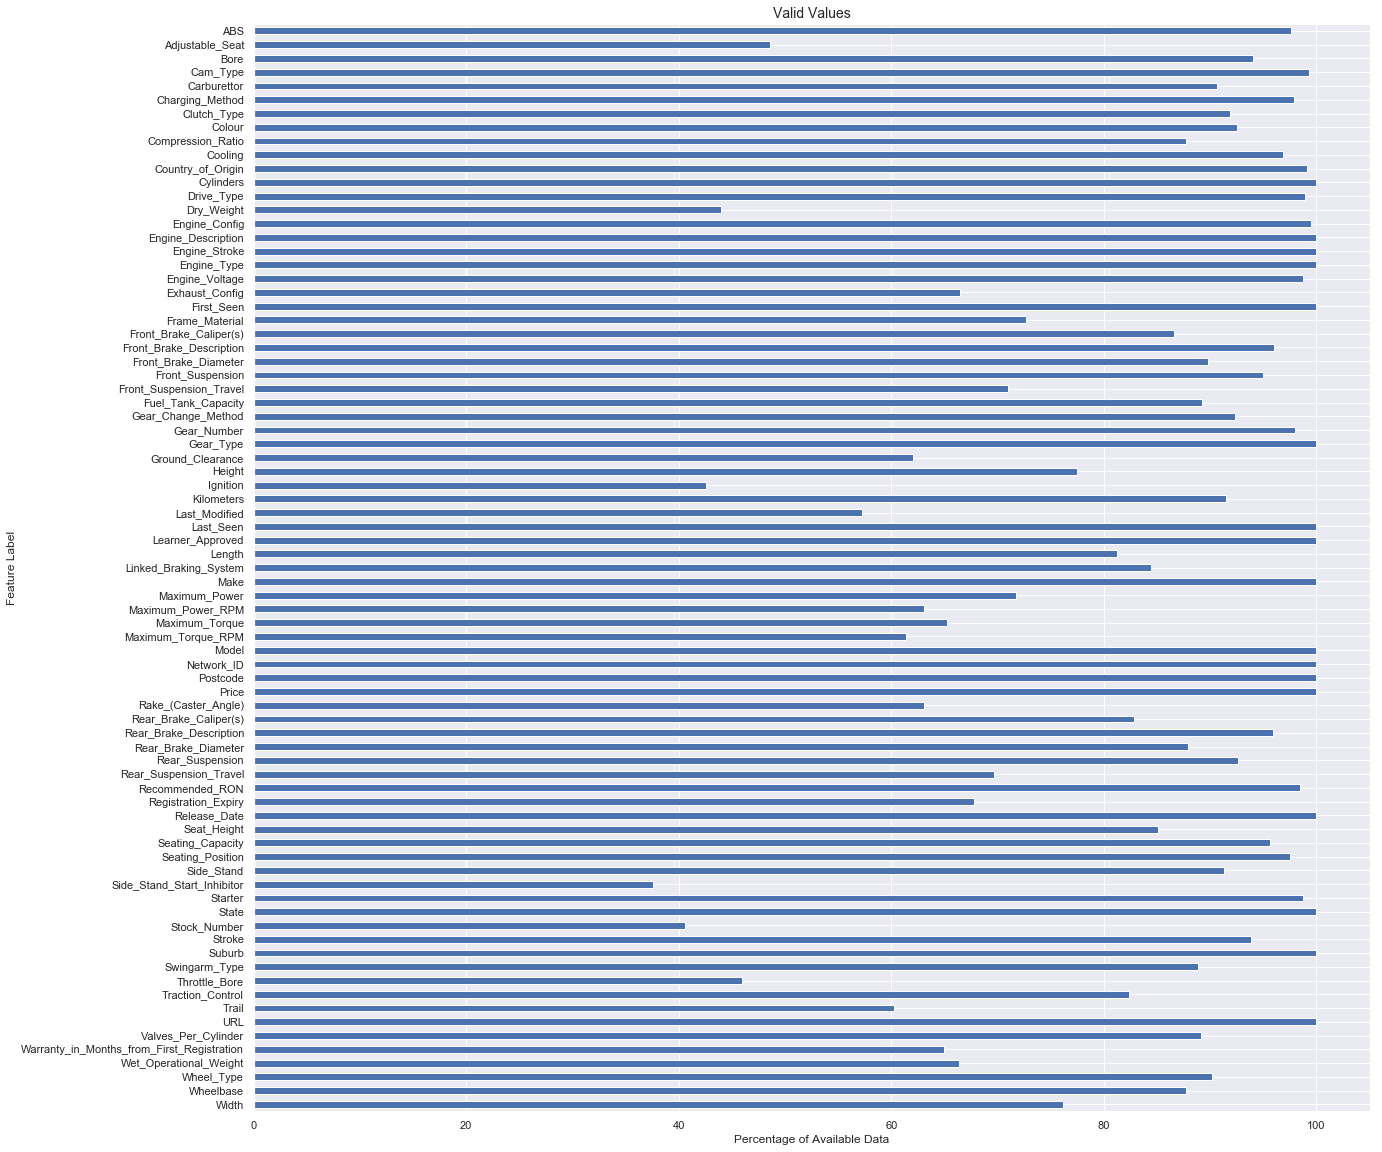

15.155% of data is missing 


In [13]:
    
missing_bar(df)

### Convert data types

Before we continue with correcting for missing values, we should make sure that all the features are of the correct data type. We will convert the numeric features into numeric datatypes removing any units associated with the values.


In [14]:
def remove_units(series, units):
    '''Remove the units from the feature.'''
    series[series.isnull() == True] = '-1.0'
    series = pd.to_numeric(series.map(lambda x: x.split(units)[0].replace(',','')),errors='coerce')
    return series.replace(-1,np.nan)

def remove_delimiters(series):
    '''Remove the known delimiters from the feature.'''
    series[series.isnull() == True] = '-1.0'
    series = series.str.replace(',','.')
    series = pd.to_numeric(series.map(lambda x: x.split(':')[0].split('to')[0].split('-')[0].split('±')[0].split('+')[0].split('.')[0]))
    return series.replace(-1,np.nan)

def replace_string(series, string, replace):
    '''Replace specified strings with a number.'''
    series = series.replace(string,replace)
    return pd.to_numeric(series,errors='ignore')

def currency_value(series):
    '''Extract just the currency values from the feature.'''
    series[series.isnull() == True] = '-1.0'
    series = pd.to_numeric(series.map(lambda x: x.split('*')[0].replace(',','').replace('$','')),errors='coerce')
    return series.replace(-1,np.nan)
    
def warranty_period(series):
    '''Standardise the values of the warrenty period.'''
    series[series == 'Optional Lifetime'] = '999'
    series[series == 'No Warranty'] = '0'
    series[series.isnull() == True] = '0'
    return pd.to_numeric(series.map(lambda x: x.split()[0]))

In [15]:

# Remove the units from the features
df['Bore'] = remove_units(df['Bore'], 'mm')
df['Throttle_Bore'] = remove_units(df['Throttle_Bore'], 'mm')
df['Dry_Weight'] = remove_units(df['Dry_Weight'], 'kg')
df['Engine_Voltage'] = remove_units(df['Engine_Voltage'], 'Volt')
df['Front_Brake_Diameter'] = remove_units(df['Front_Brake_Diameter'], 'mm')
df['Front_Suspension_Travel'] = remove_units(df['Front_Suspension_Travel'], 'mm')
df['Fuel_Tank_Capacity'] = remove_units(df['Fuel_Tank_Capacity'], 'L')
#df['Fuel_Reserve_Capacity'] = remove_units(df['Fuel_Reserve_Capacity'], 'L') # off home
df['Ground_Clearance'] = remove_units(df['Ground_Clearance'], 'mm')
df['Height'] = remove_units(df['Height'], 'mm')
df['Kilometers'] = remove_units(df['Kilometers'], 'km')
df['Length'] = remove_units(df['Length'], 'mm')
df['Maximum_Power'] = remove_units(df['Maximum_Power'], 'kW')
df['Maximum_Torque'] = remove_units(df['Maximum_Torque'], 'Nm')
#df['Oil_Capacity'] = remove_units(df['Oil_Capacity'], 'L')
df['Price'] = currency_value(df['Price'])
df['Rake_(Caster_Angle)'] = remove_units(df['Rake_(Caster_Angle)'], 'degrees')
df['Rear_Brake_Diameter'] = remove_units(df['Rear_Brake_Diameter'], 'mm')
df['Rear_Suspension_Travel'] = remove_units(df['Rear_Suspension_Travel'], 'mm')
df['Seat_Height'] = remove_units(df['Seat_Height'], 'mm')
df['Stroke'] = remove_units(df['Stroke'], 'mm')
df['Trail'] = remove_units(df['Trail'], 'mm')
df['Wet_Operational_Weight'] = remove_units(df['Wet_Operational_Weight'], 'kg')
df['Wheelbase'] = remove_units(df['Wheelbase'], 'mm')
df['Width'] = remove_units(df['Width'], 'mm')


# Extract just the number
#df['Engine_Stroke'] = df['Engine_Stroke'].str.extract('(\d+)')
df['Warranty_in_Months_from_First_Registration'] = warranty_period(df['Warranty_in_Months_from_First_Registration'])

# Remove characters
df['Compression_Ratio'] = remove_delimiters(df['Compression_Ratio'])

# Replace_string
#df['Engine_Stroke'] = replace_string(df['Engine_Stroke'],'Diesel-4','4')
#df['Warranty_KMs'] = replace_string(df['Warranty_KMs'],'Unlimited','999999')




### Standardise Features

Standardising some common values in each feature will increase the predictive power.

In [16]:
df['Model'].unique()

array(['RS 125', 'RSV1000 Mille', 'RSV1000R', 'RSV1000R Mille',
       'RSV4 Carbon SE APRC', 'RSV4 Factory', 'RSV4 Factory APRC ABS',
       'RSV4 R', 'RSV4 R APRC ABS', 'RSV4 RF', 'RSV4 RR', 'HP2 Sport',
       'HP4', 'HP4 Competition', 'R 1200 S', 'R nine T Racer',
       'R nine T Racer Spezial', 'S 1000 RR', 'S 1000 RR Race',
       'S 1000 RR Sport', 'V-Night', '1198 S', '1198 S Corse Edition',
       '1199 Panigale', '1199 Panigale S', '1299 Panigale S', '848',
       '899 Panigale', '900 Mike Hailwood Replica', '900 S2',
       '900SD Darmah', '900SS', '959 Panigale', 'Panigale V4 S',
       'Panigale V4 Speciale', 'SuperSport', 'SuperSport S',
       'CBR1000RR FireBlade', 'CBR1000RR Repsol',
       'CBR1000RRA ABS Fireblade', 'CBR125R', 'CBR250R', 'CBR250R ABS',
       'CBR300R ABS (CBR300RA)', 'CBR500R', 'CBR500RA (ABS)', 'CBR600 F',
       'CBR600RR', 'CBR650F LAMS (CBR650FL)', 'VTR1000F (Firestorm)',
       'Ninja 250R (EX250J)', 'Ninja 250R Special Edition',
       'Ninja

In [17]:
# Standardise the model values
def standardise_model(series):
    series = series.str.replace('ABS','')
    series = series.str.replace('\(ABS\)','')
    series = series.str.replace('SE 30th Anniversary','')
    series = series.str.replace('90 Year Anniversary Special Ed','')
    series = series.str.replace('20th Anniversary','')
    series = series.str.replace('30th Anniversary','')
    series = series.str.replace('Spezial','')
    series = series.str.replace('Special','')
    series = series.str.replace('Special Edition','')
    series = series.str.replace('Limited Edition','')
    series = series.str.replace('Commemorative Edition','')
    series = series.str.replace('Rossi Special','')
    
#     series = series.str.replace('Corse Edition','')
#     series = series.str.replace('Anniversario','')
    series = series.str.replace('Casey Stoner Repsol Fireblade','')
    series = series.str.replace('Repsol limited edition','')
    series = series.str.replace('Winter Edition','')
#     series = series.str.replace('Repsol limited edition','')
#     series = series.str.replace('30th Anniversary Edition','')
#     series = series.str.replace('Limited Edition','')
#     series = series.str.replace('Anniversary','')
    
#     Repsol-limited-edition
# Special-Edition
# 30th-Anniversary
#     _()
#     _-_
    
    series = series.str.replace('Mike Hailwood Replica','MHR')
    MHR_count = series.str.count('MHR')
    series[MHR_count > 1] = series[MHR_count > 1].str.replace('\(MHR\)','')
    series = series.str.replace('SUPERMOTO','Supermoto')

    series = series.str.replace('\(\)','')

    series = series.str.strip()
    #series = series.str.replace('()','')
    series = series.str.replace('-','')
    series = series.str.replace('  ',' ')
    series = series.str.replace('  ',' ')
    series = series.str.replace(' ','_')
    series = series.str.replace('--','-')
    
    series = series.str.replace('Repsol-limited-edition','')
    series = series.str.replace('Special-Edition','')
    series = series.str.replace('30th-Anniversary','')
    series = series.str.replace('_-_','')
    series = series.str.replace('Anniversary','')
    
    return series



df['Model'] = standardise_model(df['Model'])

In [18]:
df['Model'].unique()#F4_750_S_(F4S_1+1)

array(['RS_125', 'RSV1000_Mille', 'RSV1000R', 'RSV1000R_Mille',
       'RSV4_Carbon_SE_APRC', 'RSV4_Factory', 'RSV4_Factory_APRC',
       'RSV4_R', 'RSV4_R_APRC', 'RSV4_RF', 'RSV4_RR', 'HP2_Sport', 'HP4',
       'HP4_Competition', 'R_1200_S', 'R_nine_T_Racer', 'S_1000_RR',
       'S_1000_RR_Race', 'S_1000_RR_Sport', 'VNight', '1198_S',
       '1198_S_Corse_Edition', '1199_Panigale', '1199_Panigale_S',
       '1299_Panigale_S', '848', '899_Panigale', '900_MHR', '900_S2',
       '900SD_Darmah', '900SS', '959_Panigale', 'Panigale_V4_S',
       'Panigale_V4_e', 'SuperSport', 'SuperSport_S',
       'CBR1000RR_FireBlade', 'CBR1000RR_Repsol', 'CBR1000RRA_Fireblade',
       'CBR125R', 'CBR250R', 'CBR300R_(CBR300RA)', 'CBR500R', 'CBR500RA',
       'CBR600_F', 'CBR600RR', 'CBR650F_LAMS_(CBR650FL)',
       'VTR1000F_(Firestorm)', 'Ninja_250R_(EX250J)',
       'Ninja_250R_Edition', 'Ninja_300_(EX300A)', 'Ninja_300_(EX300B)',
       'Ninja_300', 'Ninja_300_Edition', 'Ninja_400_(EX400G)',
       'Ni

In [19]:
'CBR1000RR (Casey Stoner Repsol Fireblade)'.replace('Casey Stoner Repsol Fireblade','')

#     series = series.str.replace('30th Anniversary Edition','')

'CBR1000RR ()'

In [20]:
# Registration_Expiry
def standardise_registration_expiry(series):
    '''Standardise the registration dates to a common format.'''
    
    # Replace the null values with the first date the advert was seen
    null_mask = series.isnull() == True
    series[null_mask] = 0

    # Define the mask for the entries with 'month' in the value
    month_mask = series.str.contains('Month') == True
    dates = series[month_mask].str.split('-').str[-1].str.lstrip()
    series[month_mask] = pd.to_datetime(dates,format='%B %Y')

    # Replace the '00' centuries with the current.
    series = series.replace('0016','2016',regex=True);
    series = series.replace('0017','2017',regex=True);
    series = series.replace('0018','2018',regex=True);
    series = series.replace('0019','2019',regex=True);

    # Define masks for each type of date format to extract.
    mask = (series.str.split('-').isnull() == False) & \
            (series.str.split('-').str.len() > 1)
    series[mask] = pd.to_datetime(series[mask],format='%b-%y')

    mask = (series.str.split('-').isnull() == False) & \
            (series.str.split('-').str.len() == 1)
    series[mask] = pd.to_datetime(series[mask],format='%B %Y')

    # Convert the numbers into seconds.
    series = pd.to_numeric(series)/1000000000
    series[series < 0] = 0
    
    # Convert all numbers back to a standard date
    return series.map(lambda x: datetime.fromtimestamp(x).strftime("%d/%m/%Y"))
    


df['Registration_Expiry'] = standardise_registration_expiry(df['Registration_Expiry'])


In [21]:
df['Release_Year'] = df['URL'].str.split('/').str[5].str[0:4].astype('int32')

df.drop(['Release_Date'],axis=1, inplace=True)


Redefine the torque into bins to reduce variability.

In [22]:
df['Maximum_Torque'] = pd.to_numeric(
                            pd.cut(df['Maximum_Torque'],
                                   bins=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,
                                         160,170,180,190,200,210,220,230,240,250],
                                   labels=[10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,
                                           160,170,180,190,200,210,220,230,240,250]))


df['Maximum_Torque_RPM'] = pd.to_numeric(
                               pd.cut(df['Maximum_Torque_RPM'],
                                       bins=[0,500,1000,1500,2000,2500,3000,3500,4000,5000,6000,
                                             7000,8000,9000, 10000,11000,12000,13000,14000,20000],
                                       labels=[500,1000,1500,2000,2500,3000,3500,4000,5000,6000,
                                               7000,8000,9000,10000,11000,12000,13000,14000,15000]))


In [23]:

def standardize_colour(series):
    series[series.isnull() == True] = 'None'
    series[series == 'Not Specified'] = 'None'
    series[series == 'BNVL SALT'] = 'Black'

    series = series.str.split().str[0]

    lcase = lambda x: x.lower()
    series = series.map(lcase)
    series[series == 'maroon'] = 'purple'
    series[series == 'burgundy'] = 'purple'
    series[series == 'magenta'] = 'purple'
    series[series == 'beige'] = 'white'

    return series


df['Colour'] = standardize_colour(df['Colour'])

In [24]:

def standardise_state(series):
    series[series.str.contains('Western') == True] = 'WA'
    series[series.str.contains('Vic') == True] = 'VIC'
    series[series.str.contains('Tas') == True] = 'TAS'
    series[series.str.contains('New') == True] = 'NSW'
    series[series.str.contains('South') == True] = 'SA'
    series[series.str.contains('Northern') == True] = 'NT'
    series[series.str.contains('Queen') == True] = 'QLD'
    
    return series
    
    
df['State'] = standardise_state(df['State'])



In [25]:
def standardise_country(series):
    '''Standardise the values for the country of origin.'''
    series[series.isnull() == True] = 'NONE'
    ucase = lambda x: x.upper()
    series = series.map(ucase)
    series.replace('CHINA/AUSTRALIA','CHINA',inplace=True)
                    
    return series.replace('NONE',np.nan)

    
df['Country_of_Origin'] = standardise_country(df['Country_of_Origin'])

In [26]:
df['Engine_Description'] = pd.to_numeric(df['Engine_Description'],errors='coerce')

In [27]:
# Make sure there is conformity within each column and grouping any related labels together
df['Exhaust_Config'] = df['Exhaust_Config'].str.slice(stop=1)+' into '+df['Exhaust_Config'].str.slice(start=-1)


In [28]:
# Group all the supercharged labels into one.
#df['Induction_System'][df['Induction_System'].str.contains('Supercharged') == True] = 'Supercharged' 


In [29]:
# Feature engineering 
# We can use the stock number as a proxy to determine if the seller is a private individual or a dealer.
df['Seller'] = 'Private'
df['Seller'][df['Stock_Number'].isnull() == False] = 'Dealer'
df.drop(['Stock_Number'],axis=1, inplace=True)


Write current state of the data to file for later use.
- This can also be used as a starting data set on Kaggle for the full machine learning cycle 
  1. Data cleaning
  2. Imputing missing data
  3. Exploratory analysis
  4. Modelling

In [30]:
df.to_csv('BikeSales-Dusty1.csv',index=False)

I used the following interactive plots to help decide on how to impute the missing values for some features.

In [31]:

    
@interact
def plot_counts(column=df.columns):
    # remove the description 
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    
    df[column].value_counts(normalize=True).sort_index().plot(kind='bar',figsize=(12,10))
    plt.title('Distribution of Bikes',fontsize=16)
    plt.xlabel(column)
    plt.ylabel('Percentage of Bikes')
    print (df[column].isnull().sum())
    print (df[column].unique())



interactive(children=(Dropdown(description='column', options=('ABS', 'Adjustable_Seat', 'Bore', 'Cam_Type', 'C…

In [32]:
@interact
def plot_counts(x=df.select_dtypes(include='number'),
                y=df.select_dtypes(include='number'),
                Hue=df.columns):
    # remove the description 
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    correlation = df[x].corr(df[y])
    ax = sns.scatterplot(x=x,y=y, hue=Hue, data=df)
    plt.gcf().set_size_inches(10,10)
    #ax.annotate(stats.pearsonr,xytext=(0.9,0.9))
    plt.suptitle('Relationship to Price',size=24)
    plt.xlabel(x,fontsize=18)
    plt.ylabel(y,fontsize=18)


interactive(children=(Dropdown(description='x', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Dry_Weight…

## Imputing missing values

We can use our domain knowledge and the above interacive plots to impute missing vales. Some missing values we can assume that they are missing because they dont exist for the specified bike, others we will determine using the frequency of existing values or find common values for similar bikes. These will depend on the feature in question.


In [33]:
# There are a number of features that relate to other features, such as the Bore size,
# and number of Carburettors. Due to this relationship, we can use these relationships to help 
# impute missing values in the related features.

def average_ralation_to_feature(df, groupby, col, precision=3):
    '''
    Find the average value for each group which can be applied to the new column
    
    df: The dataframe.
    
    groupby: The column that has the relation to the feature with missing data.
    
    col: The feature with the missing data.
    
    precision: The precision of the results
    (Default: 3)
    '''
    
    # calcualte the average value for each col
    groups = df.groupby(by=groupby)[col].mean()
    groups = round(groups,precision)
    groups[groups.isnull() == True] = df[col].mean()

    # Populate the missing data with the average value for the corresponding grouped column.
    for item in groups.index:
        if (item in groups.keys()):
            df[col][(df[col].isnull() == True) & (df[groupby] == item)] = groups[item]

    # Replace any remaining NaN values with the feature average.
    df[col][df[col].isnull() == True] = df[col].mean()
    
    
    return df


def mode_ralation_to_feature(df, groupby, col):    
    '''
    Find the mode value for each group which can be applied to the new column
    
    df: The dataframe.
    
    groupby: The column that has the relation to the feature with missing data.
    
    col: The feature with the missing data.
    '''
        
    # calcualte the mode avlue for each column
    groups = df.groupby(by=groupby)[col].apply(lambda x: x.mode())
    
    # Populate the missing data with the average value for the corresponding grouped column.
    for item in groups.index.levels[0]:
        if (item in groups.keys()):
            df[col][(df[col].isnull() == True) & (df[groupby] == item)] = groups[item][0]

    # Replace any remaining NaN values with the most common.
    df[col][df[col].isnull() == True] = df[col].mode()[0]
    
    
    return df



First, we can address the features where a missing value means the bike doesn't have this feature.

In [34]:
df['ABS'][df['ABS'].isnull() == True] = 'No'
#df['ABS_Selectable'][df['ABS_Selectable'].isnull() == True] = 'None'
#df['Alarm'][df['Alarm'].isnull() == True] = 'No'
#df['Windscreen'][df['Windscreen'].isnull() == True] = 'No'
df['Traction_Control'][df['Traction_Control'].isnull() == True] = 'No'
#df['Top_Box'][df['Top_Box'].isnull() == True] = 'No'
#df['Heated_Hand_Grips'][df['Heated_Hand_Grips'].isnull() == True] = 'No'
df['Adjustable_Seat'][df['Adjustable_Seat'].isnull() == True] = 'No'
#df['Engine_Immobiliser'][df['Engine_Immobiliser'].isnull() == True] = 'No'
df['Linked_Braking_System'][df['Linked_Braking_System'].isnull() == True] = 'No'
#df['Warranty_KMs'][df['Warranty_KMs'].isnull() == True] = 'No'
#df['Reverse_Gear'][df['Reverse_Gear'].isnull() == True] = 'No'
#df['Roadworthy_Safety_Certificate'][df['Roadworthy_Safety_Certificate'].isnull() == True] = 'No'
#df['Saddlebags_Panniers'][df['Saddlebags_Panniers'].isnull() == True] = 'No' # off home
df['Side_Stand_Start_Inhibitor'][df['Side_Stand_Start_Inhibitor'].isnull() == True] = 'No'
df['Side_Stand'][df['Side_Stand'].isnull() == True] = 'No'

df['Last_Modified'][df['Last_Modified'].isnull() == True] = df['Last_Seen']



Use the most common value as the missing value.

In [35]:
# df['Colour'][df['Colour'].isnull() == True] = 'Not Specified'
# df['Description'][df['Description'].isnull() == True] = 'No Description'
df['Engine_Config'][df['Engine_Config'].isnull() == True] = 'Unknown'
# df['Registration_Plate'][df['Registration_Plate'].isnull() == True] = 'None'


df['Drive_Type'][df['Drive_Type'].isnull() == True] = df['Drive_Type'].mode()[0]
df['Cam_Type'][df['Cam_Type'].isnull() == True] = df['Cam_Type'].mode()[0]
df['Charging_Method'][df['Charging_Method'].isnull() == True] = df['Charging_Method'].mode()[0]
df['Compression_Ratio'][df['Compression_Ratio'].isnull() == True] = df['Compression_Ratio'].mode()
df['Cylinders'][df['Cylinders'].isnull() == True] = int(df['Cylinders'].mode()[0])
df['Engine_Stroke'][df['Engine_Stroke'].isnull() == True] = int(df['Engine_Stroke'].mode()[0])
df['Engine_Type'][df['Engine_Type'].isnull() == True] = df['Engine_Type'].mode()[0]
df['Engine_Voltage'][df['Engine_Voltage'].isnull() == True] = df['Engine_Voltage'].mode()[0]
df['Cooling'][df['Cooling'].isnull() == True] = df['Cooling'].mode()[0]
#df['Fuel_Type'][df['Fuel_Type'].isnull() == True] = df['Fuel_Type'].mode()[0]
df['Front_Brake_Caliper(s)'][df['Front_Brake_Caliper(s)'].isnull() == True] = df['Front_Brake_Caliper(s)'].mode()[0]
df['Gear_Change_Method'][df['Gear_Change_Method'].isnull() == True] = df['Gear_Change_Method'].mode()[0]
df['Gear_Number'][df['Gear_Number'].isnull() == True] = int(df['Gear_Number'].mode()[0])
df['Gear_Type'][df['Gear_Type'].isnull() == True] = df['Gear_Type'].mode()[0]
df['Ignition'][df['Ignition'].isnull() == True] = df['Ignition'].mode()[0]
#df['Induction_System'][df['Induction_System'].isnull() == True] = df['Induction_System'].mode()[0]
#df['Lock_Type'][df['Lock_Type'].isnull() == True] = df['Lock_Type'].mode()[0]
df['Rear_Brake_Caliper(s)'][df['Rear_Brake_Caliper(s)'].isnull() == True] = df['Rear_Brake_Caliper(s)'].mode()[0]
df['Recommended_RON'][df['Recommended_RON'].isnull() == True] = df['Recommended_RON'].mode()[0]
df['Seating_Capacity'][df['Seating_Capacity'].isnull() == True] = df['Seating_Capacity'].mode()[0]
df['Starter'][df['Starter'].isnull() == True] = df['Starter'].mode()[0]
df['Traction_Control'][df['Traction_Control'].isnull() == True] = df['Traction_Control'].mode()[0]


df['Front_Brake_Diameter'][df['Front_Brake_Diameter'].isnull() == True] = df['Front_Brake_Diameter'].mean()
# df['Front_Suspension_Travel'][df['Front_Suspension_Travel'].isnull() == True] = df['Front_Suspension_Travel'].mean()
# #df['Fuel_Reserve_Capacity'][df['Fuel_Reserve_Capacity'].isnull() == True] = df['Fuel_Reserve_Capacity'].mean() # off home
# df['Fuel_Tank_Capacity'][df['Fuel_Tank_Capacity'].isnull() == True] = df['Fuel_Tank_Capacity'].mean()
df['Rear_Brake_Diameter'][df['Rear_Brake_Diameter'].isnull() == True] = df['Rear_Brake_Diameter'].mean()



Some features, we can use a relationship to another feature to impute the missing values.

In [36]:
df = mode_ralation_to_feature(df, 'Model', 'Engine_Description')
df = mode_ralation_to_feature(df, 'Model', 'Engine_Config')

df = average_ralation_to_feature(df, 'Engine_Description', 'Bore', precision=3)
df = average_ralation_to_feature(df, 'Bore', 'Throttle_Bore', precision=3)
# #df = average_ralation_to_feature(df, 'Engine_Config', 'Carburettor(s)', precision=0)
# df = average_ralation_to_feature(df, 'Engine_Config', 'Engine_Description', precision=-1)
df = average_ralation_to_feature(df, 'Engine_Description', 'Dry_Weight', precision=0)
df = average_ralation_to_feature(df, 'Model', 'Ground_Clearance', precision=0)
df = average_ralation_to_feature(df, 'Model', 'Height', precision=0)
df = average_ralation_to_feature(df, 'Model', 'Seat_Height', precision=0)
df = average_ralation_to_feature(df, 'Model', 'Length', precision=0)
# df = average_ralation_to_feature(df, 'Model', 'Length', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Power', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Power_RPM', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Torque', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Maximum_Torque_RPM', precision=0)
# Max power could be improved by matching any missing values to other max power/torqu 
# values before grouping by engine_descirption

#df = average_ralation_to_feature(df, 'Engine_Description', 'Oil_Capacity', precision=1)
# df = average_ralation_to_feature(df, 'Body', 'Seat_Height', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Fuel_Tank_Capacity', precision=1)
#df = average_ralation_to_feature(df, 'Engine_Description', 'Fuel_Reserve_Capacity', precision=1)
df = average_ralation_to_feature(df, 'Engine_Description', 'Stroke', precision=3)
df = average_ralation_to_feature(df, 'Model', 'Rake_(Caster_Angle)', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Wet_Operational_Weight', precision=0)
df = average_ralation_to_feature(df, 'Engine_Description', 'Wheelbase', precision=0)
# df['Width'][df['Width'] > 1100] = np.nan
df = average_ralation_to_feature(df, 'Engine_Config', 'Width', precision=3)
df = average_ralation_to_feature(df, 'Release_Year', 'Kilometers', precision=3)


df = mode_ralation_to_feature(df, 'Model', 'Trail')
df = mode_ralation_to_feature(df, 'Make', 'Frame_Material')
df = mode_ralation_to_feature(df, 'Make', 'Front_Brake_Description')
df = mode_ralation_to_feature(df, 'Make', 'Rear_Brake_Description')
df = mode_ralation_to_feature(df, 'Make', 'Exhaust_Config')
df = mode_ralation_to_feature(df, 'Make', 'Country_of_Origin')
df = mode_ralation_to_feature(df, 'Model', 'Seating_Position')
df = mode_ralation_to_feature(df, 'Model', 'Ground_Clearance')
df = mode_ralation_to_feature(df, 'Engine_Config', 'Valves_Per_Cylinder')
df = mode_ralation_to_feature(df, 'Model', 'Ignition')
df = mode_ralation_to_feature(df, 'Model', 'Rear_Suspension_Travel')
df = mode_ralation_to_feature(df, 'Model', 'Front_Suspension_Travel')
df = mode_ralation_to_feature(df, 'Engine_Description', 'Compression_Ratio')
df = mode_ralation_to_feature(df, 'Make', 'Wheel_Type')
df = mode_ralation_to_feature(df, 'Make', 'Rear_Suspension')
df = mode_ralation_to_feature(df, 'Make', 'Front_Suspension')


# df.drop(['Configuration'],axis=1,inplace=True)

Using domain knowledge and research, we can reduce the variability of some existing features.

In [37]:

df['Carburettor'] = df['Carburettor'].str.lower()

df['Carburettor'][df['Carburettor'].str.contains('cv') == True] = 'constant velocity'
df['Carburettor'][df['Carburettor'].str.contains('constant') == True] = 'constant velocity'
df['Carburettor'][df['Carburettor'].str.contains('carb') == True] = 'carburettor'
df['Carburettor'][df['Carburettor'].str.contains('ddfi') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('defi') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('dfi ') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('dfsi') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('dell') == True] = 'dellorto'
df['Carburettor'][df['Carburettor'].str.contains('efi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('multipoint') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('electronic') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('eipi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('mpei') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('ei') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('espfi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('flat') == True] = 'flatslide'
df['Carburettor'][df['Carburettor'].str.contains('fi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pfi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pgm-dsfi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pgm-fi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('sfi') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('yfi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('fuel injected') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('mikumi') == True] = 'flatslide'
df['Carburettor'][df['Carburettor'].str.contains('mikuni') == True] = 'flatslide'
df['Carburettor'][df['Carburettor'].str.contains('multipoint sequential electronic fuel injection') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('multipoint sequential electronic injection') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pgm') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('pi') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('programmed') == True] = 'electronic fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('sdtv') == True] = 'fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('tcbi') == True] = 'digital fuel injection'
df['Carburettor'][df['Carburettor'].str.contains('throttle') == True] = 'throttle position sensor'
df['Carburettor'][df['Carburettor'].str.contains('tps') == True] = 'throttle position sensor'
df['Carburettor'][df['Carburettor'].str.contains('plunger') == True] = 'plunger'
df['Carburettor'][df['Carburettor'].str.contains('downdraft') == True] = 'downdraft'
df['Carburettor'][df['Carburettor'].str.contains('monobloc') == True] = 'monobloc'
df['Carburettor'][df['Carburettor'].str.contains('concentric') == True] = 'concentric'
df['Carburettor'][df['Carburettor'].str.contains('monobloc') == True] = 'monobloc'
df['Carburettor'][df['Carburettor'].str.contains('monobloc') == True] = 'monobloc'


possible_values = ['electronic fuel injection','dellorto','flatside','carburettor',
                   'fuel injection','constant velocity','digital fuel injection',
                   'not applicable','mechanical injection', 'indirect injection',
                   'throttle position sensor', 'plunger','downdraft','monobloc',
                  'concentric']



df['Carburettor'][(df['Carburettor'].isnull() == False) & 
                  (df['Carburettor'].isin(possible_values) == False)] = 'carburettor'

df['Carburettor'] = df['Carburettor'].str.capitalize()


In [38]:
df = mode_ralation_to_feature(df, 'Engine_Config', 'Carburettor')


In [39]:

df['Clutch_Type'] = df['Clutch_Type'].str.lower()

# df['Clutch_Type'][df['Clutch_Type'].str.contains('2-disc') == True] = 'twin plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('double disc') == True] = 'twin plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('2-disc') == True] = 'twin plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('7 friction') == True] = '7-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('8-plate') == True] = '8-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('8 plate') == True] = '8-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('10-plate') == True] = '10-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('12-plate') == True] = '12-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('3-plate') == True] = '3-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('5-disc') == True] = '5-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('5-plate') == True] = '5-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('6-plate') == True] = '6-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('7-plate') == True] = '7-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('7 plate') == True] = '7-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('7-disc') == True] = '7-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('8-plate') == True] = '8-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('9-plate') == True] = '9-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('9 plate') == True] = '9-plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('single') == True] = 'single plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('twin') == True] = 'twin plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('dual') == True] = 'twin plate'
# df['Clutch_Type'][df['Clutch_Type'].str.contains('triple') == True] = '3-plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('aptc') == True] = 'adler power torque clutch'
df['Clutch_Type'][df['Clutch_Type'].str.contains('anti-hop') == True] = 'anti-hop'
df['Clutch_Type'][df['Clutch_Type'].str.contains('antii-hop') == True] = 'anti-hop'
df['Clutch_Type'][df['Clutch_Type'].str.contains('automatic') == True] = 'automatic'
df['Clutch_Type'][df['Clutch_Type'].str.contains('centrifugal') == True] = 'centrifugal'
df['Clutch_Type'][df['Clutch_Type'].str.contains('multi') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('mulit') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('disc') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('plate') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('multiple') == True] = 'multi plate'
df['Clutch_Type'][df['Clutch_Type'].str.contains('electronically') == True] = 'electronically controlled'
df['Clutch_Type'][df['Clutch_Type'].str.contains('hydraulic') == True] = 'hydraulically operated'
df['Clutch_Type'][df['Clutch_Type'].str.contains('slipper') == True] = 'slipper'
df['Clutch_Type'][df['Clutch_Type'].str.contains('ultramatic') == True] = 'ultramatic'
df['Clutch_Type'][df['Clutch_Type'].str.contains('wet') == True] = 'wet'
df['Clutch_Type'][df['Clutch_Type'].str.contains('dry') == True] = 'dry'
df['Clutch_Type'][df['Clutch_Type'].str.contains('clutchless') == True] = 'clutchless'
df['Clutch_Type'][df['Clutch_Type'].str.contains('mechanical') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('foot') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('cable') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('manual') == True] = 'mechanical'
df['Clutch_Type'][df['Clutch_Type'].str.contains('twist') == True] = 'twist shift'

possible_values = ['multi plate', 'automatic', 'centrifugal', 'wet', 'dry', 'slipper', 
                   'hydraulically operated', 'adler power torque clutch', 'anti-hop', 
                   'clutchless', 'electronically controlled', 'mechanical', 'twist shift']

df['Clutch_Type'][(df['Clutch_Type'].isnull() == False) & 
                  (df['Clutch_Type'].isin(possible_values) == False)] = 'other'

df['Clutch_Type'][df['Clutch_Type'].isnull() == True] = df['Clutch_Type'].mode()[0]

df['Clutch_Type'] = df['Clutch_Type'].str.capitalize()


In [40]:
df['Drive_Type'][df['Drive_Type'].str.contains('Belt') == True] = 'Belt'
df['Drive_Type'][df['Drive_Type'].str.contains('Chain') == True] = 'Chain'
df['Drive_Type'][df['Drive_Type'].str.contains('Shaft') == True] = 'Shaft'
df['Drive_Type'][df['Drive_Type'].str.contains('Direct') == True] = 'Chain'
df['Drive_Type'][df['Drive_Type'].str.contains('Gear') == True] = 'Gear'

#df['Drive_Type'][df['Drive_Type'].isnull() == True] = df['Drive_Type'].mode()[0]



In [41]:
df['Wheel_Type'] = df['Wheel_Type'].str.lower()

df['Wheel_Type'][df['Wheel_Type'].str.contains('36') == True] = 'Laced'
df['Wheel_Type'][df['Wheel_Type'].str.contains('spoke') == True] = 'Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('3') == True] = 'Y-Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('muilti') == True] = 'Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('multi') == True] = 'Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('multti') == True] = 'Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('laced') == True] = 'Laced'
df['Wheel_Type'][df['Wheel_Type'].str.contains('cross') == True] = 'Laced'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y-shape') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y shape') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y-spoke') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('y spoke') == True] = 'Y Shape'
df['Wheel_Type'][df['Wheel_Type'].str.contains('star') == True] = 'Spoke'
df['Wheel_Type'][df['Wheel_Type'].str.contains('solid') == True] = 'Solid'

df['Wheel_Type'][df['Wheel_Type'].str.contains('aum') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('alum') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('cast') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('alloy') == True] = 'Aluminium'
df['Wheel_Type'][df['Wheel_Type'].str.contains('chrom') == True] = 'Chrome'
df['Wheel_Type'][df['Wheel_Type'].str.contains('steel') == True] = 'Steel'
df['Wheel_Type'][df['Wheel_Type'].str.contains('alumite') == True] = 'Alumite Rims'
df['Wheel_Type'][df['Wheel_Type'].str.contains('carbon') == True] = 'Carbon Fibre'
df['Wheel_Type'][df['Wheel_Type'].str.contains('custom') == True] = 'Custom'




possible_values = ['Laced','Spoke','Y-Shape','Aluminium','Chrome','Steel',
                   'Alumite Rims','Carbon Fibre','Custom', 'Solid']
    
df['Wheel_Type'][(df['Wheel_Type'].isnull() == False) & 
                 (df['Wheel_Type'].isin(possible_values) == False)] = 'Other'

In [42]:
df['Swingarm_Type'][df['Swingarm_Type'].str.contains('Single') == True] = 'Single Sided'
df['Swingarm_Type'][df['Swingarm_Type'].str.contains('Dual') == True] = 'Dual Sided'

df['Swingarm_Type'][df['Swingarm_Type'].isnull() == True] = df['Swingarm_Type'].mode()[0]


In [43]:
def group_brake_description(df, feature):
    ''' Group the similar types of brake descriptions using common terms. '''
    
    df[feature] = df[feature].str.lower()
    
    df[feature][df[feature].str.contains('hydraulic') == True] = 'Hydraulic'
    df[feature][df[feature].str.contains('calliper') == True] = 'Calliper'
    df[feature][df[feature].str.contains('disc') == True] = 'Disc'
    df[feature][df[feature].str.contains('disk') == True] = 'Disc'
    df[feature][df[feature].str.contains('rotor') == True] = 'Disc'
    df[feature][df[feature].str.contains('piston') == True] = 'Piston'
    df[feature][df[feature].str.contains('drum') == True] = 'Drum'
    df[feature][df[feature].str.contains('shoe') == True] = 'Drum'
    df[feature][df[feature].str.contains('expanding') == True] = 'Expanding'
    df[feature][df[feature].str.contains('power') == True] = 'Power Assisted'
    df[feature][df[feature].str.contains('mechanical') == True] = 'Calliper'
    df[feature][df[feature].str.contains('expanding') == True] = 'Expanding'

    possible_values = ['Hydraulic','Calliper','Disc','Drum','Piston','Expanding','Power Assisted']

    
    df[feature][(df[feature].isnull() == False) & (df[feature].isin(possible_values) == False)] = 'Other'
    
    
    return df[feature]


In [44]:
df['Front_Brake_Description'] = group_brake_description(df,'Front_Brake_Description')
df['Rear_Brake_Description'] = group_brake_description(df,'Rear_Brake_Description')


In [45]:
def group_suspension(df,feature):
    ''' Group the similar types of suspensions using common terms. '''
    
    df[feature] = df[feature].str.lower()
        
    df[feature][df[feature].str.contains('hydraulic') == True] = 'Hydraulic'
    df[feature][df[feature].str.contains('telesc') == True] = 'Telescopic'
    df[feature][df[feature].str.contains('inverted') == True] = 'Inverted'
    df[feature][df[feature].str.contains('spring') == True] = 'Spring'
    df[feature][df[feature].str.contains('upside') == True] = 'Upside Down'
    df[feature][df[feature].str.contains('up side') == True] = 'Upside Down'
    df[feature][df[feature].str.contains('shock') == True] = 'Shock'
    df[feature][df[feature].str.contains('air') == True] = 'Air'
    df[feature][df[feature].str.contains('fork') == True] = 'Conventional Fork'
    df[feature][df[feature].str.contains('adjustable') == True] = 'Adjustable'
 

    df[feature][df[feature].str.contains('Front Suspension') == True] = np.nan
    df[feature][df[feature].str.contains('Nil') == True] = np.nan


    possible_values = ['Telescopic','Inverted','Upside Down','Hydraulic','Shock',
                       'Spring','Air','Conventional Fork','Adjustable']


    df[feature][(df[feature].isnull() == False) & 
                (df[feature].isin(possible_values) == False)] = 'Other'

    return df[feature]


In [46]:
df['Front_Suspension'] = group_suspension(df,'Front_Suspension')
df['Rear_Suspension'] = group_suspension(df,'Rear_Suspension')

In [47]:
def group_material(df,feature):
    ''' Group the similar types of materials used, using common terms. '''
   
    df[feature] = df[feature].str.lower()
   
    df[feature][df[feature].str.contains('chrom') == True] = 'Chrome'
    df[feature][df[feature].str.contains('25crmo4') == True] = 'Chrome'
    df[feature][df[feature].str.contains('steel') == True] = 'Steel'
    df[feature][df[feature].str.contains('aum') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('alum') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('allum') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('cast') == True] = 'Aluminium'
    df[feature][df[feature].str.contains('magnesium') == True] = 'Magnesium'
    df[feature][df[feature].str.contains('titanium') == True] = 'Titanium'
    df[feature][df[feature].str.contains('alloy') == True] = 'Alloy'
    df[feature][df[feature].str.contains('composite') == True] = 'Composite'
    df[feature][df[feature].str.contains('monolever') == True] = 'Monolever'
    df[feature][df[feature].str.contains('asymmetric') == True] = 'Asymmetric'
    df[feature][df[feature].str.contains('carbon') == True] = 'Carbon Fibre'
    df[feature][df[feature].str.contains('manganese') == True] = 'Manganese'
    df[feature][df[feature].str.contains('polyethylene') == True] = 'Polyethylene'

    possible_values = ['Chrome','Steel','Aluminium','Magnesium','Titanium','Alloy',
                       'Composite','Monolever','Asymmetric','Carbon Fibre',
                       'Manganese','Polyethylene']

    df[feature][(df[feature].isnull() == False) & 
            (df[feature].isin(possible_values) == False)] = 'Other'

    return df[feature]

In [48]:
df['Frame_Material'] = group_material(df,'Frame_Material')

After imputing all the missing values, remove any features that have 1 unique value

In [49]:
remove_list = []

for col in list(df.columns):
    # ignore nans in the list
    items = [x for x in list(df[col].unique()) if (str(x) != 'nan')]
    
    if ((len(items) == 1) & (col != 'Last_Seen')):
        remove_list.append(col)
        print (col,df[col].isnull().sum()/df.shape[0])

print ('Columns before: ',len(df.columns))
df.drop(remove_list,axis=1, inplace=True)
print ('Columns after: ',len(df.columns))


Columns before:  79
Columns after:  79


In [50]:
categories = df.select_dtypes(include='object')

for category in categories:
    df[category] = df[category].str.replace(' ','_')
    


Make sure we have dealt with all the missing values.

In [51]:
null_features = []
for col in df.columns:
    if (df[col].isnull().sum() > 0):
        print (col,df[col].isnull().sum())
        null_features.append(col)
    
    
    
    

In [52]:
df.shape

(3141, 79)

Write the cleaned data to file.

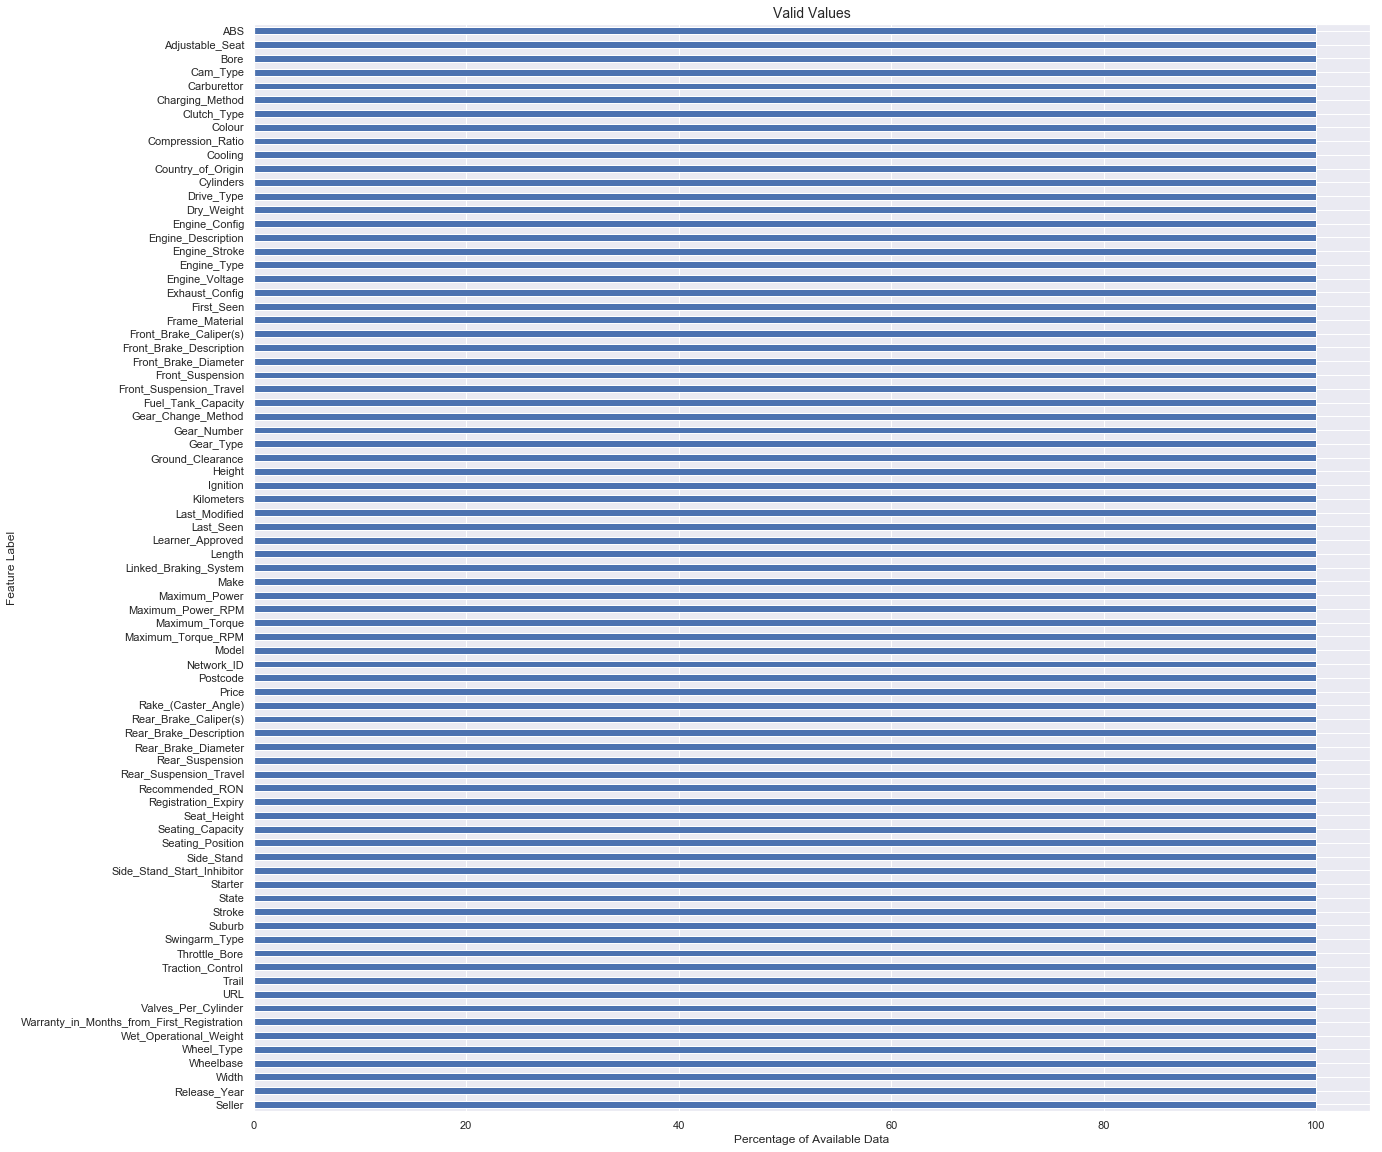

0.0% of data is missing 


In [53]:
df.to_csv('BikeSales-Dusty2.csv',index=False)
missing_bar(df)

In [54]:
  
# @interact
# def plot_counts(column=null_features):
#     # remove the description 
#     #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    
#     df[column].value_counts(normalize=True).sort_index().plot(kind='bar',figsize=(12,10))
#     plt.title('Distribution of Bikes',fontsize=16)
#     plt.xlabel(column)
#     plt.ylabel('Percentage of Bikes')
#     print (df[column].isnull().sum())
#     print (df[column].unique())
 